In [25]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [26]:
!kaggle datasets download -d gpiosenka/100-bird-species

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
!kaggle datasets download -d ichhadhari/indian-birds

100% 5.30G/5.30G [04:54<00:00, 22.4MB/s]
100% 5.30G/5.30G [04:54<00:00, 19.3MB/s]


In [27]:
!unzip -q 100-bird-species.zip

replace EfficientNetB0-525-(224 X 224)- 98.97.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip -q indian-birds.zip

In [28]:
!pip install pytorch_lightning

In [29]:
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from pytorch_lightning.loggers import CSVLogger
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pytorch_lightning as pl
import numpy as np

**Part 1**

**Note: the birds.csv file is corrupted (the paths of the images is not true for all images).
so we are making a file that contains the path of the image and its label for each data subset (train and test).**

**first for the train subset**

In [ ]:

# Specify the parent directory containing subfolders with train images
parent_directory = "/content/train"
cols = ["FilePath", "Label"]
train_df = pd.DataFrame(columns=cols)
# Loop through subdirectories
for subdir, dirs, files in os.walk(parent_directory):
    for file in files:
      # the full path to the image file
      image_path = os.path.join(subdir, file)
      new_row_data = {"FilePath": image_path, "Label": subdir}
      train_df.loc[len(train_df)] = new_row_data

train_df['Label'] = train_df['Label'] .str.extract(r'train/(.*)')

**now for the test subset**

In [ ]:
# Specify the parent directory containing subfolders with test images
parent_directory = "/content/test"
cols = ["FilePath", "Label"]
test_df = pd.DataFrame(columns=cols)
# Loop through subdirectories
for subdir, dirs, files in os.walk(parent_directory):
    for file in files:
      # the full path to the image file
      image_path = os.path.join(subdir, file)
      new_row_data = {"FilePath": image_path, "Label": subdir}
      test_df.loc[len(test_df)] = new_row_data

test_df['Label'] = test_df['Label'] .str.extract(r'test/(.*)')

**one more for the validation subset**

In [ ]:
# Specify the parent directory containing subfolders with validation images
parent_directory = "/content/valid"
cols = ["FilePath", "Label"]
valid_df = pd.DataFrame(columns=cols)
# Loop through subdirectories
for subdir, dirs, files in os.walk(parent_directory):
    for file in files:
      # the full path to the image file
      image_path = os.path.join(subdir, file)
      new_row_data = {"FilePath": image_path, "Label": subdir}
      valid_df.loc[len(valid_df)] = new_row_data

valid_df['Label'] = valid_df['Label'] .str.extract(r'valid/(.*)')

**Some statistics on the data subsets**

In [ ]:
from PIL import Image
image = Image.open(train_df.loc[0, "FilePath"])

# Display basic information about the image
print("Image path:", image_path)
print("Image format:", image.format)
print("Image mode:", image.mode)
print("Image size:", image.size)

Image path: /content/valid/INLAND DOTTEREL/4.jpg
Image format: JPEG
Image mode: RGB
Image size: (224, 224)


In [ ]:
print("Number of samples in train subset is: ", train_df.shape[0])
print("Number of samples in test subset is: ", test_df.shape[0])
print("Number of samples in validation subset is: ", valid_df.shape[0])

Number of samples in train subset is:  84635
Number of samples in test subset is:  2625
Number of samples in validation subset is:  2625


In [ ]:
print("Number of bird species in dataset: ", train_df['Label'].nunique())

Number of bird species in dataset:  525


In [ ]:
print(f"Distribution of the species in the train subset:\n{train_df['Label'].value_counts()}")

Distribution of the species in the train subset:
RUFOUS TREPE               263
HOUSE FINCH                248
D-ARNAUDS BARBET           233
OVENBIRD                   233
ASIAN GREEN BEE EATER      220
                          ... 
NORTHERN RED BISHOP        130
RED TAILED THRUSH          130
EURASIAN GOLDEN ORIOLE     130
AMETHYST WOODSTAR          130
PATAGONIAN SIERRA FINCH    130
Name: Label, Length: 525, dtype: int64


**Some Distribution plots on the data subsets**

**Label Distribution plot on training subset**

<ipython-input-19-790f8afd163e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)


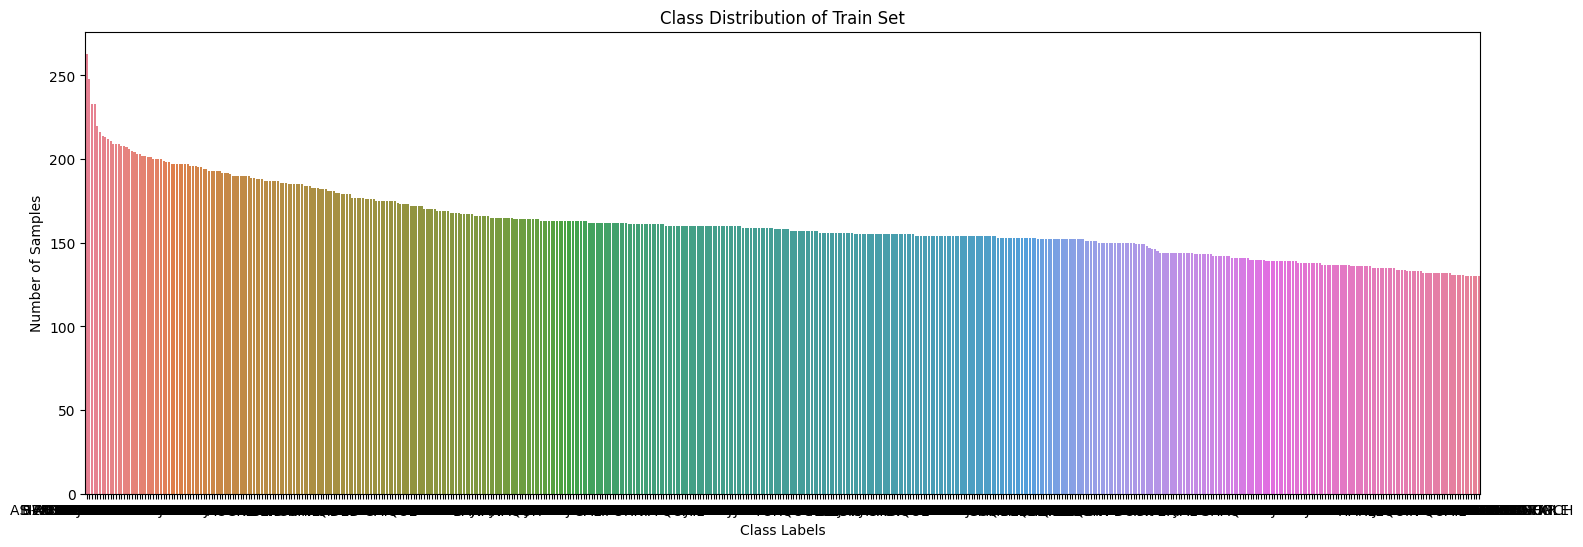

In [ ]:


labels = train_df['Label']
# Count the occurrences of each class label
label_counts = labels.value_counts()

# Create a color palette with distinct colors for each category
colors = sns.color_palette("husl", len(label_counts))

# Create a bar plot using seaborn with the specified colors
plt.figure(figsize=(18, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)

# Set plot title and labels
plt.title('Class Distribution of Train Set')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

# Display the plot
plt.show()


**Label Distribution plot on test subset**

<ipython-input-20-1c45561ca455>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)


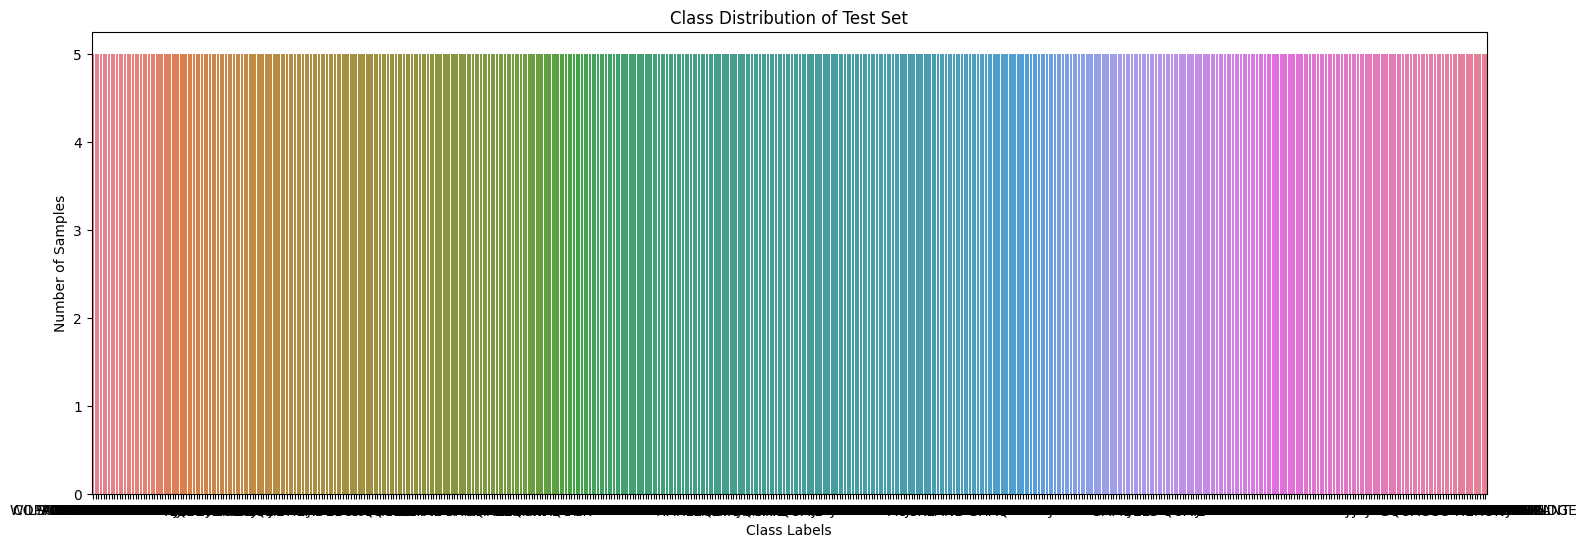

In [ ]:
labels = test_df['Label']
# Count the occurrences of each class label
label_counts = labels.value_counts()

# Create a color palette with distinct colors for each category
colors = sns.color_palette("husl", len(label_counts))

# Create a bar plot using seaborn with the specified colors
plt.figure(figsize=(18, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)

# Set plot title and labels
plt.title('Class Distribution of Test Set')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

# Display the plot
plt.show()

**Label Distribution plot on validation subset**

<ipython-input-21-ac079f1de98d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)


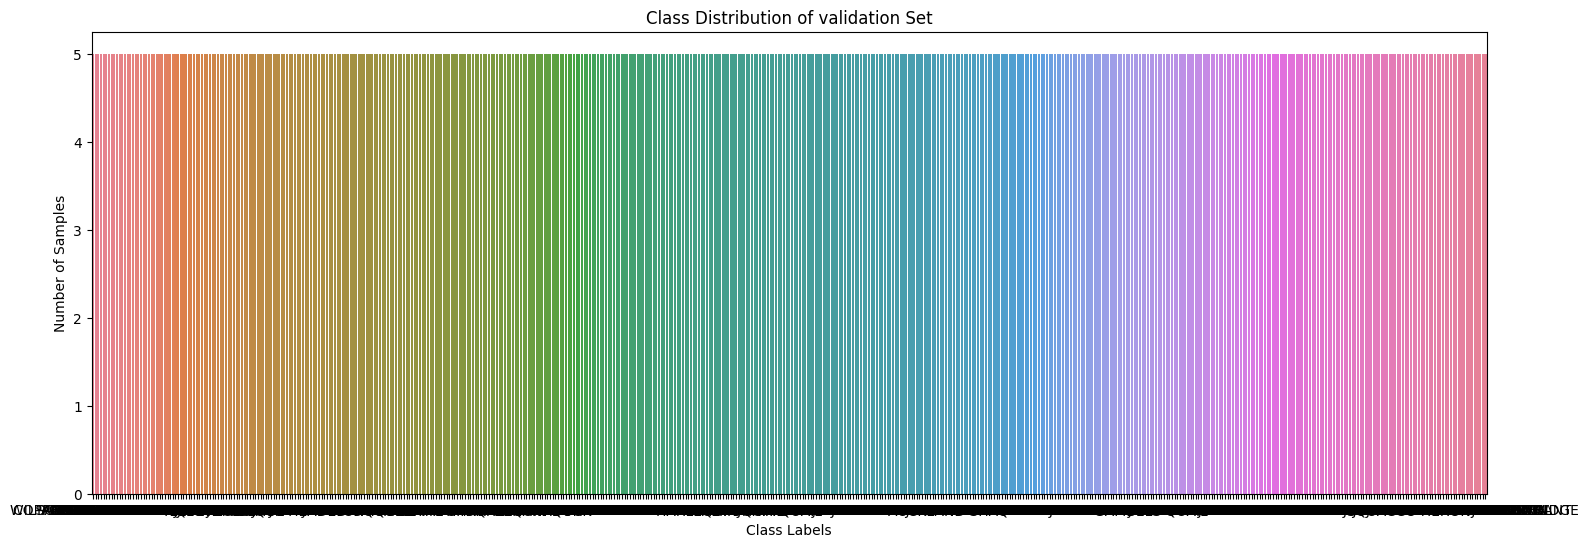

In [ ]:
labels = valid_df['Label']
# Count the occurrences of each class label
label_counts = labels.value_counts()

# Create a color palette with distinct colors for each category
colors = sns.color_palette("husl", len(label_counts))

# Create a bar plot using seaborn with the specified colors
plt.figure(figsize=(18, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)

# Set plot title and labels
plt.title('Class Distribution of validation Set')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

# Display the plot
plt.show()

**Image Sample from the data**

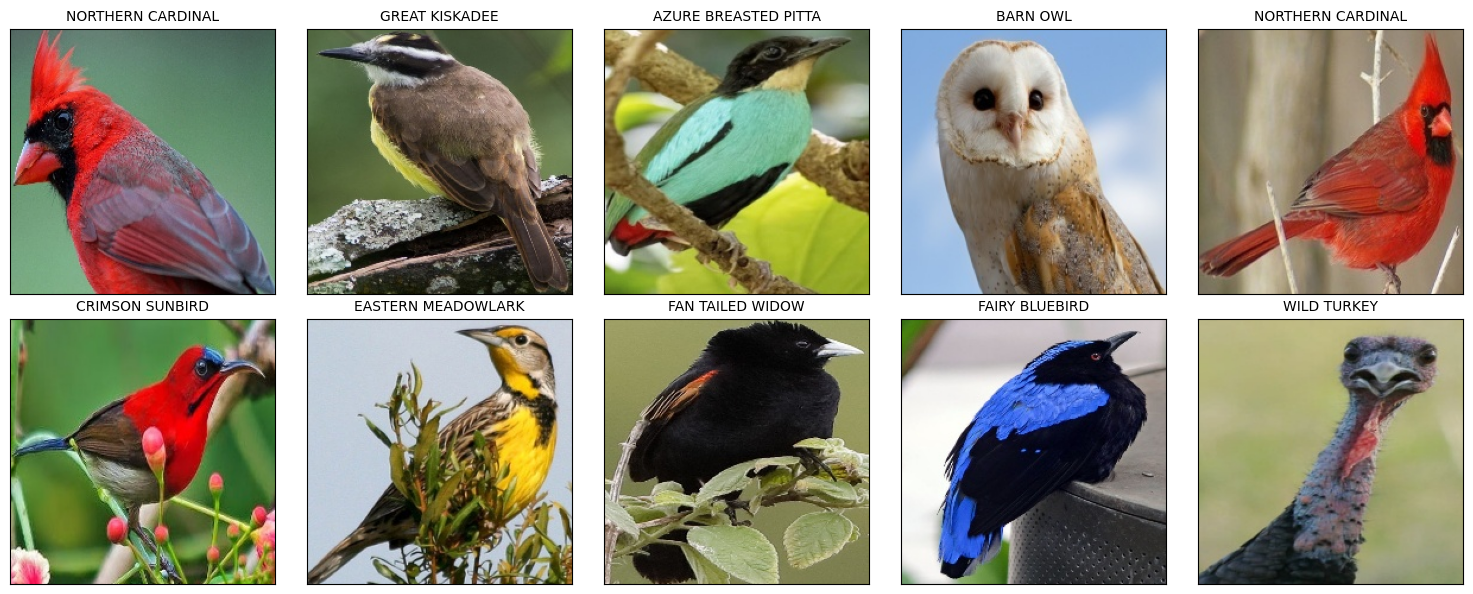

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df['FilePath'][random_index[i]]))
    ax.set_title(train_df.Label[random_index[i]], fontsize=10)
plt.tight_layout()
plt.show()

**Encoding the data Labels**

In [ ]:
label_encoder = LabelEncoder()

train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
train_df['Label']= train_df['Label'].astype('int64')
test_df['Label'] = label_encoder.fit_transform(test_df['Label'])
test_df['Label']= test_df['Label'].astype('int64')
valid_df['Label'] = label_encoder.fit_transform(valid_df['Label'])
valid_df['Label']= valid_df['Label'].astype('int64')


train_df.to_csv('birds_train.csv')
test_df.to_csv('birds_test.csv')
valid_df.to_csv('birds_valid.csv')

**Part 2:**

**Implemnting the BirdsDataSet**

In [31]:

class BirdsDataSet(Dataset):
    def __init__(self, csv_file, transform=None):
        self.images = pd.read_csv(csv_file)
        self.data = self.images['FilePath']
        self.targets = self.images['Label']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]
        image = Image.open(img_name)
        label = self.targets[idx]

        if self.transform:
          image = self.transform(image)

        return image, label

**Implemnting the initial CNNModel**

In [32]:

class CNNModel(pl.LightningModule):
    def __init__(self, num_classes=525):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same')
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding='same')
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same')
        self.avgpool5 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.global_pooling = nn.AdaptiveAvgPool2d((1, 1))

        # The output size after adaptive pooling will be (64, 1, 1)
        self.fc1 = nn.Linear(256, 400)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(400, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.avgpool3(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.avgpool5(x)

        # Adaptive pooling reduces spatial dimensions to (1, 1)
        x = self.global_pooling(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())

        loss_val =  nn.CrossEntropyLoss()(preds, Y_batch.long())
        self.log("Train Loss: ", loss_val)

        acc = self.compute_acc(preds, Y_batch)
        self.log("Train Acc: ", acc)
        return loss_val

    def validation_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())

        loss_val = nn.CrossEntropyLoss()(preds, Y_batch.long())
        acc = self.compute_acc(preds, Y_batch)

        self.log("Vall Loss: ", loss_val)
        self.log("Val Acc: ", acc)

        return loss_val

    def test_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())

        loss_test =  nn.CrossEntropyLoss()(preds, Y_batch.long())
        self.log("Test Loss: ", loss_test)

        return loss_test

    def predict_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())
        acc = self.compute_acc(preds, Y_batch)

        return acc

    def compute_acc(self, y_hats, ys):
         # Get predicted labels
        probabilities = F.softmax(y_hats, dim=1)
        _, predicted_labels = torch.max(probabilities, 1)

        # Compute accuracy
        accuracy = torch.sum(predicted_labels == ys).item() / ys.numel()

        return accuracy

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

**Implemnting the CNNModelImproved after the improvment**

In [33]:
class CNNModelImproved(pl.LightningModule):
    def __init__(self, num_classes=525):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Add Batch Normalization to subsequent convolutional layers
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same')
        self.bn5 = nn.BatchNorm2d(256)
        self.avgpool5 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.global_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 400)
        # self.dropout = nn.Dropout(0.5)  # Add dropout
        self.fc2 = nn.Linear(400, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.avgpool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.avgpool5(x)

        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())

        loss_val =  nn.CrossEntropyLoss()(preds, Y_batch.long())
        self.log("Train Loss: ", loss_val)

        acc = self.compute_acc(preds, Y_batch)
        self.log("Train Acc: ", acc)
        return loss_val

    def validation_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())

        loss_val = nn.CrossEntropyLoss()(preds, Y_batch.long())
        acc = self.compute_acc(preds, Y_batch)

        self.log("Vall Loss: ", loss_val)
        self.log("Val Acc: ", acc)

        return loss_val

    def test_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())

        loss_test =  nn.CrossEntropyLoss()(preds, Y_batch.long())
        self.log("Test Loss: ", loss_test)

        return loss_test

    def predict_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self(X_batch.float())
        acc = self.compute_acc(preds, Y_batch)

        return acc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

    def compute_acc(self, y_hats, ys):
        # Get predicted labels
        probabilities = F.softmax(y_hats, dim=1)
        _, predicted_labels = torch.max(probabilities, 1)

        # # Compute accuracy
        accuracy = torch.sum(predicted_labels == ys).item() / ys.numel()

        return accuracy



**Training the initial CNNModule**

In [ ]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
dataset = BirdsDataSet("/content/birds_train.csv", transform=transform)

# Set up k-fold cross-validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

log_dir = "logs"
model_name = "SimpleCNN"

# Use CSVLogger to log results to a CSV file
csv_logger_Simple = CSVLogger(save_dir=log_dir, name="simple_cnn_logs")

# Training loop with k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(dataset.data, dataset.targets)):
    print(f"Fold {fold + 1}/{k_folds}")

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    classifier = CNNModel()

    #pl.seed_everything(42, workers=True)
    trainer = pl.Trainer(max_epochs=20, logger = csv_logger_Simple)

    trainer.fit(classifier, train_loader, val_loader)
    trainer.save_checkpoint("Models/" + model_name + str(fold) + ".ckpt")


**A tranform on the log csv file so we could use it to draw the learning curve**

In [ ]:

metrics_file_path = os.path.join(csv_logger_Simple.log_dir, 'metrics.csv')

# Read the CSV file using pandas
log_data = pd.read_csv(metrics_file_path)
log_data.to_csv("simple_metrics.csv")

In [9]:
log = pd.read_csv("/content/simple_metrics.csv")
val_log = log[log['Val Acc: '].notnull()]

In [10]:
rows = []
i = 0
for index in val_log.index:
  train_row = log.iloc[index-1]
  val_row = val_log.iloc[i]
  if train_row['epoch'] == val_row['epoch']:
    joined_row = [train_row['epoch'], train_row['Train Acc: '], train_row['Train Loss: '], val_row['Val Acc: '], val_row['Vall Loss: ']]
    rows.append(joined_row)
    i+=1

columns = ['epoch', 'Train Acc', 'Train Loss', 'Vall Acc', 'Vall Loss']
train_val_log = pd.DataFrame(rows, columns=columns)


In [11]:
train_val_log.head()

,epoch,Train Acc,Train Loss,Vall Acc,Vall Loss
0,0.0,0.000000,6.259535,0.003131,6.257719
1,1.0,0.015625,5.335377,0.033379,5.213826
2,2.0,0.125000,4.430138,0.118450,4.372380
3,3.0,0.218750,4.181002,0.204171,3.797516
4,4.0,0.296875,3.576815,0.264961,3.387577


**Plot Learning curve of the simple CNNModel for each fold of the 5 folds**

Model at Fold 1:


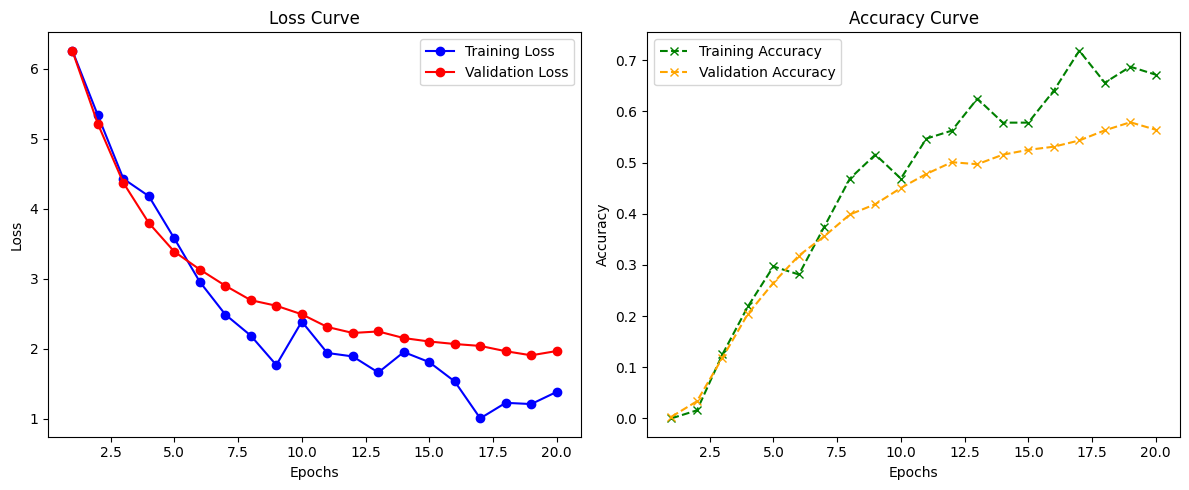

Model at Fold 2:


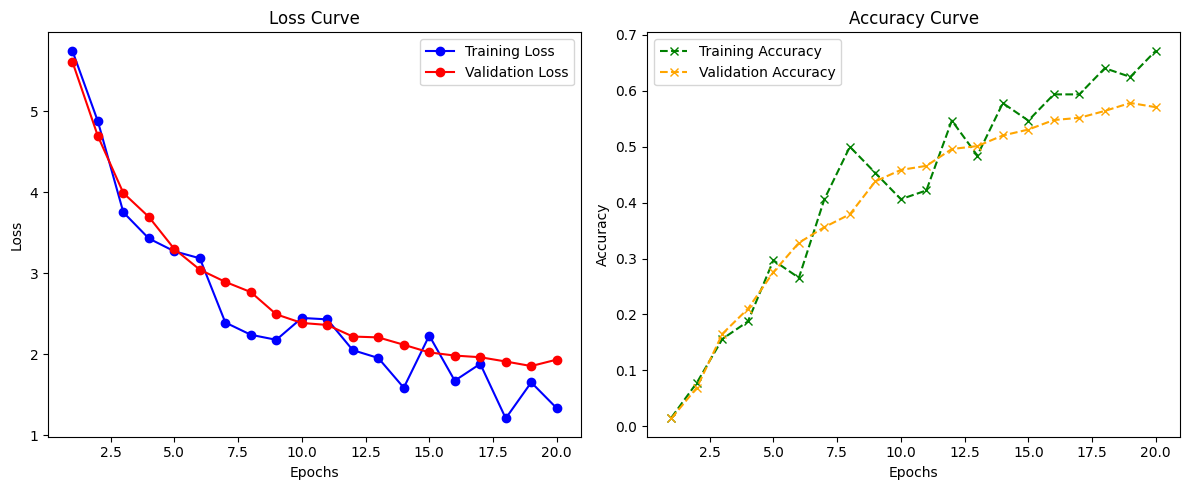

Model at Fold 3:


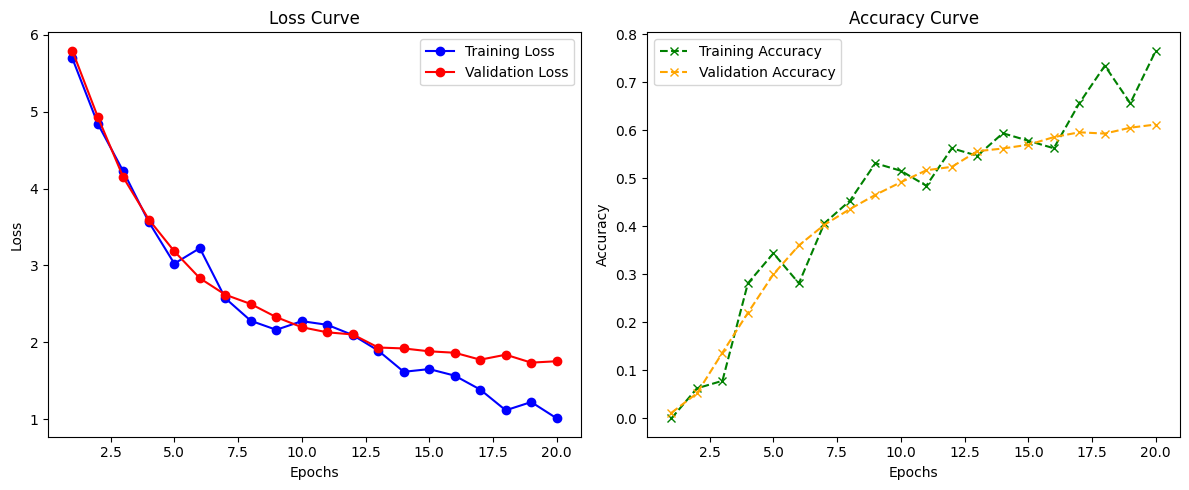

Model at Fold 4:


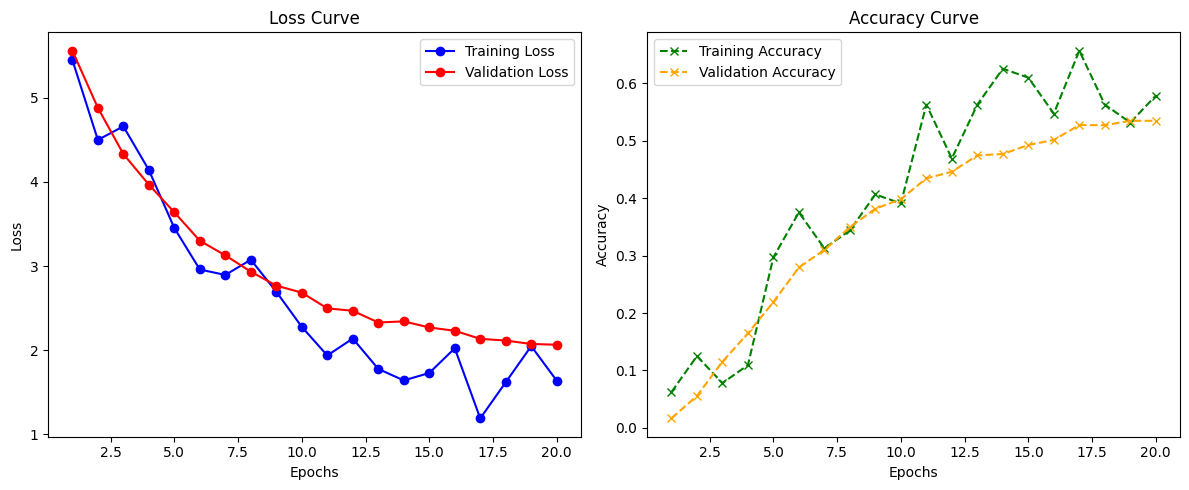

Model at Fold 5:


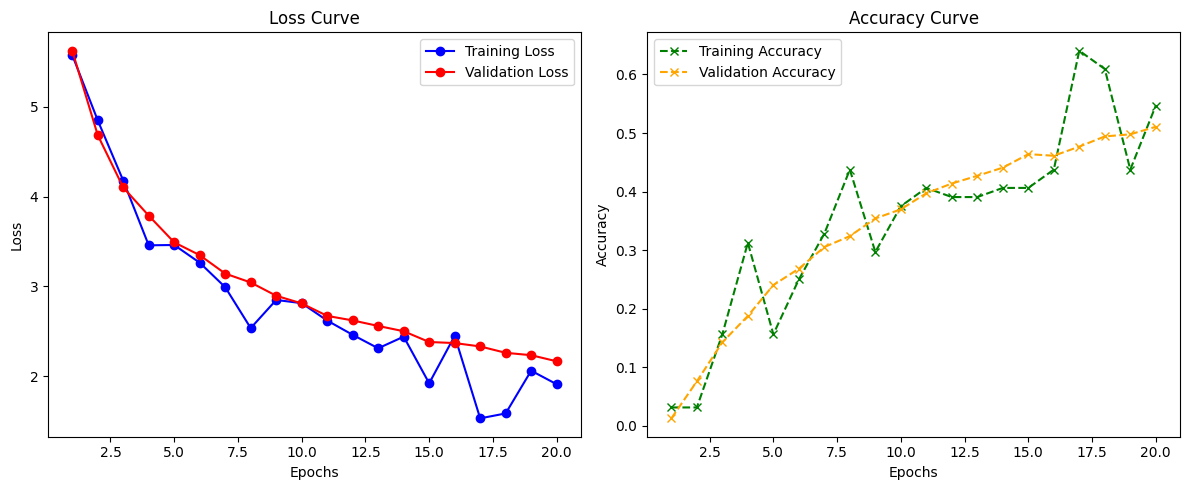

In [12]:

# Split the DataFrame into 5 equal parts
foldes = np.array_split(train_val_log, 5)
epochs = [i for i in range(1,21)]



# Display each slice
for i, fold_df in enumerate(foldes):
  print(f"Model at Fold {i+1}:")
  train_loss = list(fold_df['Train Loss'])
  val_loss = list(fold_df['Vall Loss'])
  train_acc = list(fold_df['Train Acc'])
  val_acc = list(fold_df['Vall Acc'])

  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  # Plot training and validation loss
  axs[0].plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
  axs[0].plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')

  # Plot training and validation accuracy
  axs[1].plot(epochs, train_acc, label='Training Accuracy', color='green', linestyle='--', marker='x')
  axs[1].plot(epochs, val_acc, label='Validation Accuracy', color='orange', linestyle='--', marker='x')

  # Add labels and title for each subplot
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].set_title('Loss Curve')
  axs[0].legend()

  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_title('Accuracy Curve')
  axs[1].legend()

  # Show plot
  plt.tight_layout()
  plt.show()



**Acuracy of each simple CNNModel on each fold on the test set**

In [ ]:

test_dataset = BirdsDataSet("/content/birds_test.csv", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)

for fold in range(5):
  model = CNNModel()

  # Load the saved state dictionary
  loaded_state_dict = torch.load(f'Models/SimpleCNN{fold}.ckpt')

  # Set the model to evaluation mode
  model.eval()

  # Load the state dictionary into the model
  model.load_state_dict(loaded_state_dict['state_dict'])
  device = 'cuda'
  all_predictions = []
  all_true_labels = []
  model.to(device)

  # Iterate over the test loader
  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          probabilities = F.softmax(outputs, dim=1)
          predictions = probabilities.argmax(dim=1)
          all_predictions.extend(predictions.cpu().numpy())
          all_true_labels.extend(targets.cpu().numpy())

  # Convert lists to numpy arrays
  all_predictions = np.array(all_predictions)
  all_true_labels = np.array(all_true_labels)

  # Compute accuracy
  accuracy = (all_predictions == all_true_labels).mean()
  print(f"Accuracy of CNNModule on Fold_{fold+1}: {accuracy * 100:.2f}%")




**Training the Improved CNNModule**

In [ ]:
# Set up k-fold cross-validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

log_dir = "logs"
model_name = "ImprovedCNN"

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
dataset = BirdsDataSet("/content/birds_train.csv", transform=transform)

# Use CSVLogger to log results to a CSV file
csv_logger_Improved = CSVLogger(save_dir=log_dir, name="Improved_cnn_logs")

# Training loop with k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(dataset.data, dataset.targets)):
    print(f"Fold {fold + 1}/{k_folds}")

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    classifier = CNNModelImproved()

    trainer = pl.Trainer(max_epochs=15, logger = csv_logger_Improved)

    trainer.fit(classifier, train_loader, val_loader)
    trainer.save_checkpoint("Models/" + model_name + str(fold) + ".ckpt")



**A tranform on the log csv file so we could use it to draw the learning curve**

In [ ]:

metrics_file_path = os.path.join(csv_logger_Improved.log_dir, 'metrics.csv')

# Read the CSV file using pandas
log_data = pd.read_csv(metrics_file_path)
log_data.to_csv("Improved_metrics.csv")

In [ ]:
log = pd.read_csv("/content/Improved_metrics.csv")
val_log = log[log['Val Acc: '].notnull()]
rows = []
i = 0
for index in val_log.index:
  train_row = log.iloc[index-1]
  val_row = val_log.iloc[i]
  if train_row['epoch'] == val_row['epoch']:
    joined_row = [train_row['epoch'], train_row['Train Acc: '], train_row['Train Loss: '], val_row['Val Acc: '], val_row['Vall Loss: ']]
    rows.append(joined_row)
    i+=1

columns = ['epoch', 'Train Acc', 'Train Loss', 'Vall Acc', 'Vall Loss']
train_val_log = pd.DataFrame(rows, columns=columns)

**Plot Learning curve of the Improved CNNModel for each fold of the 5 folds**

Model at Fold 1:


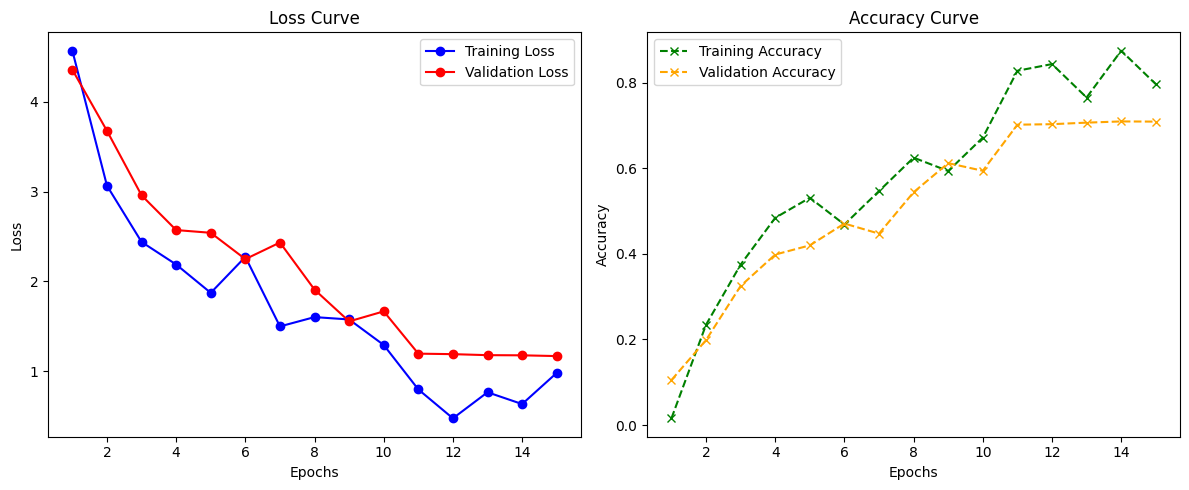

Model at Fold 2:


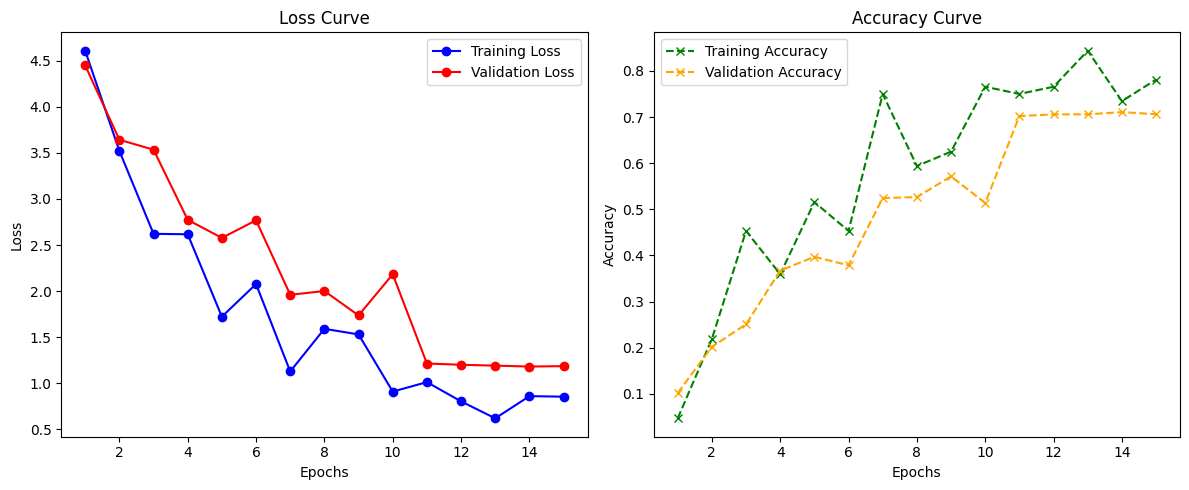

Model at Fold 3:


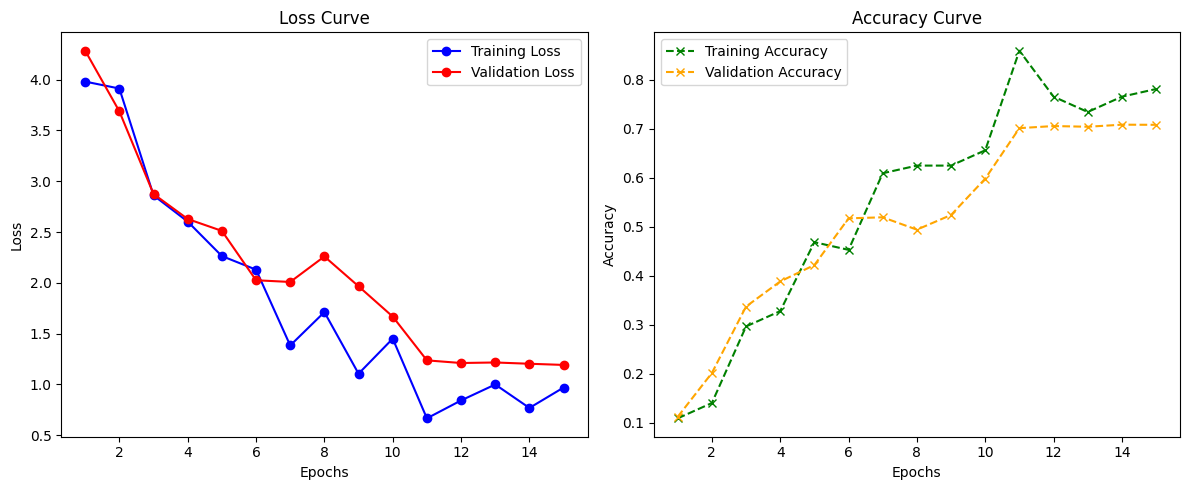

Model at Fold 4:


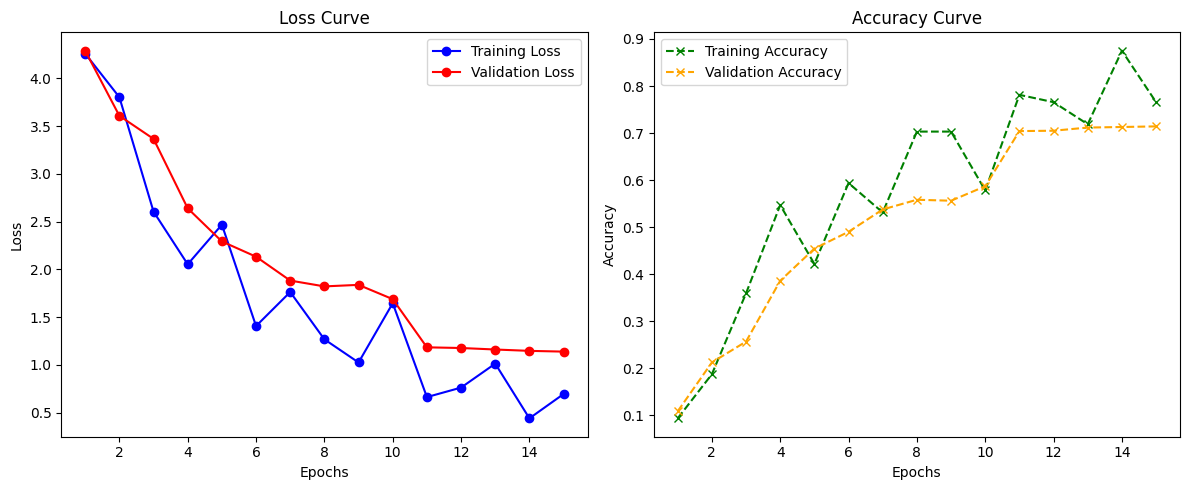

Model at Fold 5:


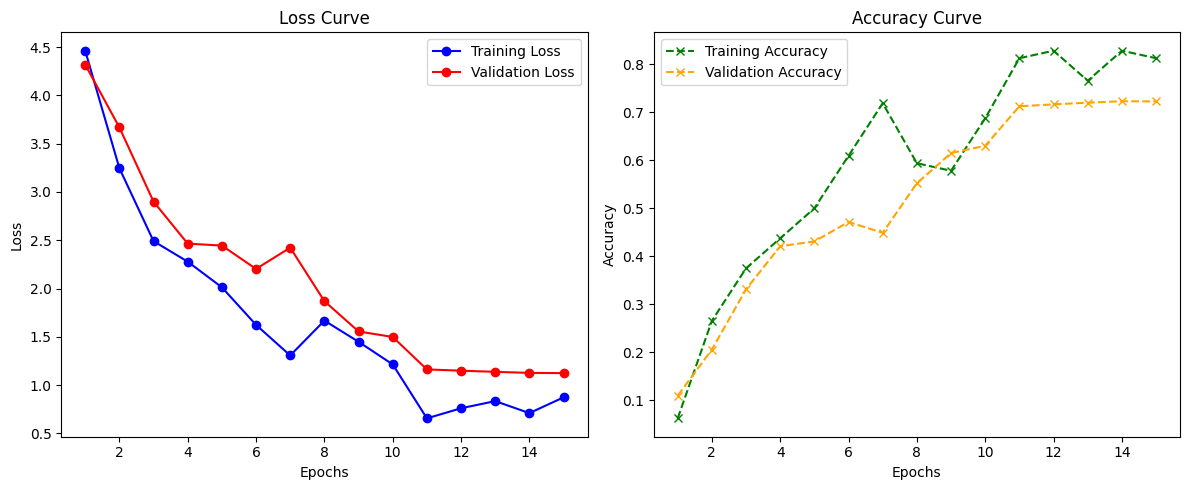

In [ ]:


# Split the DataFrame into 5 equal parts
foldes = np.array_split(train_val_log, 5)
epochs = [i for i in range(1,16)]



# Display each slice
for i, fold_df in enumerate(foldes):
  print(f"Model at Fold {i+1}:")
  train_loss = list(fold_df['Train Loss'])
  val_loss = list(fold_df['Vall Loss'])
  train_acc = list(fold_df['Train Acc'])
  val_acc = list(fold_df['Vall Acc'])

  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  # Plot training and validation loss
  axs[0].plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
  axs[0].plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')

  # Plot training and validation accuracy
  axs[1].plot(epochs, train_acc, label='Training Accuracy', color='green', linestyle='--', marker='x')
  axs[1].plot(epochs, val_acc, label='Validation Accuracy', color='orange', linestyle='--', marker='x')

  # Add labels and title for each subplot
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].set_title('Loss Curve')
  axs[0].legend()

  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_title('Accuracy Curve')
  axs[1].legend()

  # Show plot
  plt.tight_layout()
  plt.show()

**Acuracy of each Improved CNNModel on each fold on the test set**

In [ ]:

test_dataset = BirdsDataSet("/content/birds_test.csv", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)

for fold in range(5):
  model = CNNModelImproved()

  # Load the saved state dictionary
  loaded_state_dict = torch.load(f'Models/ImprovedCNN{fold}.ckpt')

  # Set the model to evaluation mode
  model.eval()

  # Load the state dictionary into the model
  model.load_state_dict(loaded_state_dict['state_dict'])
  device = 'cuda'
  all_predictions = []
  all_true_labels = []
  model.to(device)

  # Iterate over the test loader
  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          probabilities = F.softmax(outputs, dim=1)
          predictions = probabilities.argmax(dim=1)
          all_predictions.extend(predictions.cpu().numpy())
          all_true_labels.extend(targets.cpu().numpy())

  # Convert lists to numpy arrays
  all_predictions = np.array(all_predictions)
  all_true_labels = np.array(all_true_labels)

  # Compute accuracy
  accuracy = (all_predictions == all_true_labels).mean()
  print(f"Accuracy of ImprovedCNNModule on Fold_{fold+1}: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of ImprovedCNNModule on Fold_1: 80.19%
Accuracy of ImprovedCNNModule on Fold_2: 79.73%
Accuracy of ImprovedCNNModule on Fold_3: 80.30%
Accuracy of ImprovedCNNModule on Fold_4: 80.27%
Accuracy of ImprovedCNNModule on Fold_5: 80.91%


**Part 2 question D:**

In [38]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Resize((224, 224))  # Resize the image to (224, 224)
])

test_dataset = BirdsDataSet("/content/birds_test.csv", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)
#loaded_state_dict = torch.load(f'Models/ImprovedCNN4.ckpt')
loaded_state_dict = torch.load(f'/content/epoch=14-step=15870-v4.ckpt')
model = CNNModelImproved()
model.eval()

# Load the state dictionary into the model
model.load_state_dict(loaded_state_dict['state_dict'])
device = 'cuda'
all_predictions = []
all_true_labels = []
model.to(device)

# Iterate over the test loader
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        predictions = probabilities.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Compute accuracy
accuracy = (all_predictions == all_true_labels).mean()
print(f"Accuracy of ImprovedCNNModule after augmentation on test sample: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of ImprovedCNNModule after augmentation on test sample: 73.87%


**We used this chunk of code in order to examine the best Improved CNNModel performance**

In [ ]:
# we use two list "bad" and "good" on order to examine the model performance.
# the good list is a list where the model truely pridected the correct class giving him a probapility of above 0.9
# to be the correct class (points of power of the model), the bad list is a list where the model didnt predicted the
# correct class with probapility of below 0.1.
# the object of the two lists are also a list containing the tensor coresponding to the image, the true Label,
# the predicted Label and the probapility given by the model to the correct Label.

# after we didcted the performance based on the two list we got manually by loking at the images,
# in the report pdf we will explain more about that.

best_CNNModel = CNNModelImproved()

# Load the saved state dictionary
loaded_state_dict = torch.load(f'Model/ImprovedCNN3.ckpt')

# Set the model to evaluation mode
best_CNNModel.eval()

# Load the state dictionary into the model
best_CNNModel.load_state_dict(loaded_state_dict['state_dict'])
best_CNNModel.to(device)

bad = []
good = []

#Iterate over the test loader
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_CNNModel(inputs)
        probabilities = F.softmax(outputs, dim=1)
        predictions = probabilities.argmax(dim=1)
        for i in range(64):
          if probabilities.shape[0] == 64:
            if predictions[i] != targets[i]:
              if probabilities[i][int(targets[i])] < 0.01:
                bad.append([inputs[i], targets[i], predictions[i], probabilities[i][int(targets[i])]])

            elif predictions[i] == targets[i]:
              if probabilities[i][int(targets[i])] > 0.9:
                good.append([inputs[i], targets[i], probabilities[i][int(targets[i])]])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


**Training Improved Model with a new class**

In [ ]:
log_dir = "logs"
model_name = "ImprovedCNN526"
dataset = BirdsDataSet("/content/526.csv", transform=transform)
csv_logger_Improved526 = CSVLogger(save_dir=log_dir, name="Improved_cnn_logs526")
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

classifier = CNNModelImproved(num_classes=526)
classifier.to(device)
trainer = pl.Trainer(max_epochs=15, logger = csv_logger_Improved526)

trainer.fit(classifier, train_loader)
trainer.save_checkpoint("Models/" + model_name + ".ckpt")

In [ ]:
metrics_file_path = os.path.join(csv_logger_Improved.log_dir, 'metrics.csv')

# Read the CSV file using pandas
log_data = pd.read_csv(metrics_file_path)
log_data.to_csv("Improved526_metrics.csv")

**Plot Learning curve of the Improved CNNModel with the new class**

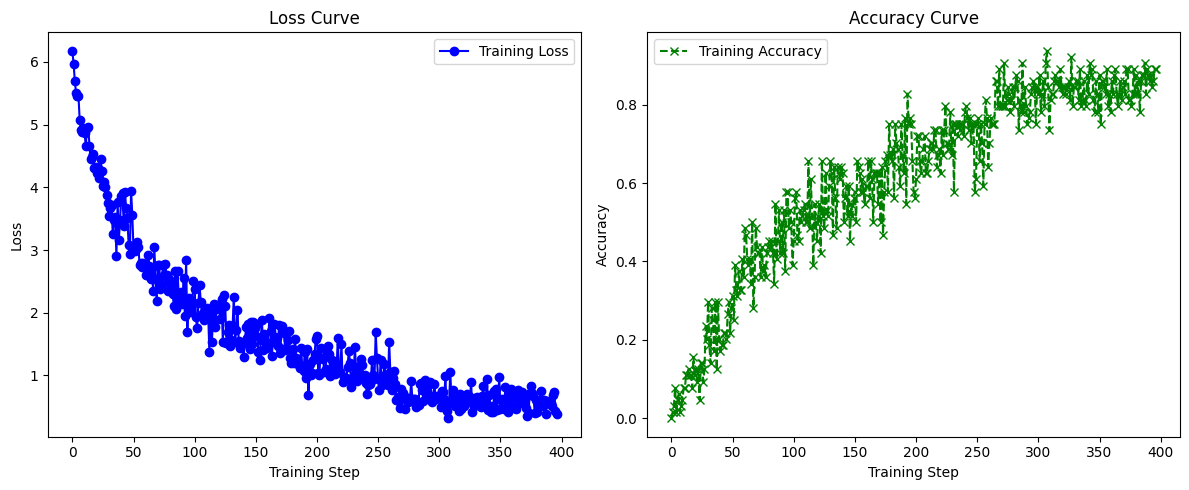

In [14]:
# we are Ploting the learning curve based on train step and not epoch and only on the train set.
# we wanted to do k cross validation also on this model but due of the lack of time and computing power resources
# we couldnt manage to do that.

train_log_526 = pd.read_csv('/content/Improved526_metrics.csv')
epochs = [i for i in range(len(train_log_526))]



train_loss = list(train_log_526['Train Loss: '])
train_acc = list(train_log_526['Train Acc: '])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot training and validation loss
axs[0].plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
# Plot training and validation accuracy
axs[1].plot(epochs, train_acc, label='Training Accuracy', color='green', linestyle='--', marker='x')

# Add labels and title for each subplot
axs[0].set_xlabel('Training Step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Curve')
axs[0].legend()

axs[1].set_xlabel('Training Step')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].legend()

# Show plot
plt.tight_layout()
plt.show()

**Predict using the new Model**

In [63]:
# we will attache the csv to the files in order to run this cell.
# we just added to the old test set a sample of 200 image file path and label of the new class to the file.

test_dataset = BirdsDataSet("/content/test_526.csv", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)
loaded_state_dict = torch.load(f'Models/ImprovedCNN526.ckpt')
model = CNNModelImproved(num_classes=526)
model.eval()

# Load the state dictionary into the model
model.load_state_dict(loaded_state_dict['state_dict'])
device = 'cuda'
all_predictions = []
all_true_labels = []
model.to(device)

# Iterate over the test loader
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        predictions = probabilities.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Compute accuracy
accuracy = (all_predictions == all_true_labels).mean()
print(f"Accuracy of ImprovedCNNModule on 526 Labels: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of ImprovedCNNModule on 526 Labels: 83.95%


**Perfomance of the new model with 526 Labels on the new species**

In [71]:
CNNModel526 = CNNModelImproved(num_classes=526)

# Load the saved state dictionary
loaded_state_dict = torch.load(f'Models/ImprovedCNN526.ckpt')

# Set the model to evaluation mode
CNNModel526.eval()

# Load the state dictionary into the model
CNNModel526.load_state_dict(loaded_state_dict['state_dict'])
CNNModel526.to(device)

bad = []
good = []

#Iterate over the test loader
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = CNNModel526(inputs)
        probabilities = F.softmax(outputs, dim=1)
        predictions = probabilities.argmax(dim=1)
        if probabilities.shape[0] == 64:
          for i in range(64):
              if predictions[i] == 525:
                bad.append([inputs[i], targets[i], probabilities[i][int(targets[i])]])
        else:
          for i in range(6):
            if targets[i] == 525:
                good.append([targets[i], predictions[i]])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


**We can see that the model didnt predict any of the 525 species as the new Label**

In [74]:
bad

[]

**The model only failed in one of the new examples**

In [73]:
good

[[tensor(525, device='cuda:0'), tensor(525, device='cuda:0')],
 [tensor(525, device='cuda:0'), tensor(525, device='cuda:0')],
 [tensor(525, device='cuda:0'), tensor(525, device='cuda:0')],
 [tensor(525, device='cuda:0'), tensor(525, device='cuda:0')],
 [tensor(525, device='cuda:0'), tensor(9, device='cuda:0')]]